<a href="https://colab.research.google.com/github/papipopapu/PhysicsThings/blob/main/FluidSym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import numba as nb
import typing as tp
import math

In [2]:
from scipy.interpolate import RectBivariateSpline 
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation 
from matplotlib import rcParams
rcParams['animation.ffmpeg_path'] =  '/content/drive/MyDrive/Animaciones/ffmpeg/bin/ffmpeg.exe'
!chmod 755 '/content/drive/MyDrive/Animaciones/ffmpeg/bin/ffmpeg.exe'

In [235]:

@nb.njit()
def noForceI(v: np.array, t: float, dt: float):
  return v

@nb.njit()
def noForceJ(u: np.array, t: float, dt: float):
  return u

@nb.njit()
def noInk(ink: np.array, t: float, dt: float):
  return ink



class fluidThings:
  def __init__(self, Ni: int, Nj: int, dh: float, forceSourceI = noForceI, forceSourceJ = noForceJ, inkSource = noInk): # add you source functions, arguments above

    self._forceSourceJ = forceSourceJ
    self._forceSourceI = forceSourceI
    self._inkSource = inkSource
    self._time = 0
    self._Ni = Ni # Number of fluid cells on a dimension
    self._Nj = Nj
    self._dh = dh # Size of a cell 
    self._dt = 0.1

    umgrid = np.mgrid[0:Ni, 0:Nj + 1]
    vmgrid = np.mgrid[0:Ni + 1, 0:Nj]
    smgrid = np.mgrid[0:Ni + 2, 0:Nj + 2]


    self._u = np.arange(Ni*(Nj+1)).reshape(Ni, Nj+1) # Field of vx velocities in walls (named u), to zeros when we can initialize initial conditions with method
    self._uSpline = RectBivariateSpline(np.arange(Ni), np.arange(Nj+1), self._u) # Smooth interpolation
   # print (self._u ) # to remove check

    self._uPos =  fluidThings.uPos(np.vstack((umgrid[0].flatten(), umgrid[1].flatten())), Ni, dh)        
    #print (self._uPos)

    self._v = np.arange(Nj*(Ni+1)).reshape(Ni+1, Nj) # Field of vy velocities in walls (named v)
    self._vSpline = RectBivariateSpline(np.arange(Ni+1), np.arange(Nj), self._v)
   # print (self._v )

    self._vPos =  fluidThings.vPos(np.vstack((vmgrid[0].flatten(), vmgrid[1].flatten())), Ni, dh)  


    self._p = np.arange((Ni+2)*(Nj+2)).reshape(Ni+2, Nj+2)
    self._pSpline = RectBivariateSpline(np.arange(Ni+2), np.arange(Nj+2), self._p)  # presssure, is defined on solid cells -> n+2
  #  print (self._p )

    self._ink = np.arange((Ni+2)*(Nj+2)).reshape(Ni+2, Nj+2)
    self._inkSpline = RectBivariateSpline(np.arange(Ni+2), np.arange(Nj+2), self._p) # zero on solid cell walls?
   # print (self._ink ) # to remove check

    self._sPos =  fluidThings.sPos(np.vstack((smgrid[0].flatten(), smgrid[1].flatten())), Ni, dh)  

    self._A = fluidThings.basicA(Ni, Nj)
    self._sA = scipy.sparse.csr_matrix(np.matrix(self._A))



  @staticmethod
  @nb.njit()
  def basicA(Ni: int, Nj: int):
    A = np.zeros((Ni*Nj, Ni*Nj)) 
    k = 0
    for i in np.arange(Ni):
      for j in np.arange(Nj):
        row = np.zeros((Ni, Nj))
        adjF = 0
        if (i > 0):
          adjF += 1
          row[i - 1, j] = 1
        if (j > 0):
          adjF += 1
          row[i, j-1] = 1
        if (i < Ni - 1):
          adjF += 1
          row[i + 1, j] = 1
        if (j < Nj - 1):
          adjF += 1
          row[i, j + 1] = 1
        row[i, j] = -adjF
        A[k, :] = row.flatten()
        k += 1
    return A
    
  

  @staticmethod
  @nb.njit()
  def trimmedDx(Field: np.array): # its trimmed specially to be added to velocities in x
    trim = Field[1:-1, :]
    Dx = trim[:, 1:] - trim[:, :-1]

    return Dx

  @staticmethod
  @nb.njit()
  def trimmedDy(Field: np.array): # its trimmed specially to be added to velocities in y
    trim = Field[:, 1:-1]
    Dy = trim[1:, :] - trim[:-1, :]

    return Dy

  @staticmethod
  @nb.njit()
  def uIdx(r: np.array, Ni: int, dh: float): # idx = [[ui],[uj]], this functions gets x,y and returns indices for u 
    idx = np.zeros((2, r[0].size));
    xScaled = r[0]/dh 
    yScaled = r[1]/dh

    idx[0] = -yScaled + Ni - 0.5 # u_i
    idx[1] = xScaled # u_j


    return idx

  @staticmethod
  @nb.njit()
  def vIdx(r: np.array, Ni: int, dh: float): # idx = [[vi],[vj]], this functions gets x,y and returns indices for v
    idx = np.zeros((4, r[0].size));
    xScaled = r[0]/dh 
    yScaled = r[1]/dh

    idx[0] = -yScaled + Ni # v_i
    idx[1] = xScaled - 0.5 # v_j

    return idx

    
  @staticmethod
  @nb.njit()
  def sIdx(r: np.array, Ni: int, dh: float): # idx = [[si],[sj]] , for ink or pressure
    idx = np.zeros((2, r[0].size));

    idx[0] = Ni - r[1]/dh + 0.5 # u_j
    idx[1] = r[0]/dh + 0.5

    return idx
  
  @staticmethod
  @nb.njit() # now we give idx and get position xy
  def uPos(idx: np.array, Ni: int, dh: float):
    r = np.zeros((2, idx[0].size))

    r[1] = (Ni - idx[0] - 0.5) * dh # y
    r[0] = idx[1] * dh # x

    return r

  @staticmethod
  @nb.njit() # now we give idx and get position xy
  def vPos(idx: np.array, Ni: int, dh: float):
    r = np.zeros((2, idx[0].size))

    r[1] = (Ni - idx[0]) * dh # y
    r[0] = (idx[1] + 0.5) * dh # x

    return r

  @staticmethod
  @nb.njit() # now we give idx and get position xy
  def sPos(idx: np.array, Ni: int, dh: float):
    r = np.zeros((2, idx[0].size))

    r[1] = (Ni - idx[0] + 0.5) * dh # y
    r[0] = (idx[1] - 0.5) * dh # x

    return r



  @staticmethod
  @nb.njit()
  def dtGet(u: np.array, v: np.array, dh: float):
    mod = u[:, 1:] ** 2 + v[1:, :] ** 2 # not quite but idk besiuñagt
    maxu = np.amax(mod)
    dt = min(5 * dh / math.sqrt(maxu), 0.1)
    return dt


  def fu(self, r: np.array): # r = [[x],[y]], return u
    idx = self.uIdx(r, self._Ni, self._dh); # get indices
    u = self._uSpline.ev(idx[0], idx[1]) # interpolate
    return u

  def fv(self, r: np.array): # r = [[x],[y]], return v
    idx = self.vIdx(r, self._Ni, self._dh); # get indices
    v = self._vSpline.ev(idx[0], idx[1]) # interpolate 
    return v

     

  def fp(self, r: np.array): # return [p]
    idx = self.sIdx(r, self._Ni, self._dh); # get indices
    p = self._pSpline.ev(idx[0], idx[1])

    return p


  def fink(self, r: np.array): # return [ink]
    idx = self.sIdx(r, self._Ni, self._dh); # get indices
    ink = self._inkSpline.ev(idx[0], idx[1])

    return ink

  def backHeun(self, r: np.array): # r = [[x], [y]] 
    umid = np.vstack((self.fu(r), self.fv(r)))
    rmid = r - self._dt * umid
    rn = r - self._dt * 0.5 * (umid + np.vstack((self.fu(r), self.fv(r))))

    return rn

  def InitialConditions(self, u: np.array, v: np.array, dt: float):
    self._dt = dt
    self._u = u
    self._uSpline = RectBivariateSpline(np.arange(self._Ni), np.arange(self._Nj+1), self._u) # Smooth interpolation
    self._v = v
    self._vSpline = RectBivariateSpline(np.arange(self._Ni+1), np.arange(self._Nj), self._v) # Smooth interpolation


  def test(self): # for testing
    f = self.trimmedDx(self._p)

    
    return f
  
  def step(self):

   # self._dt = fluidThings.dtGet(self._u, self._v, self._dh) # get time step

    self._u = self._forceSourceJ(self._u, self._time, self._dt) # add forces
    self._v = self._forceSourceI(self._v, self._time, self._dt)

    
    tempu = (self.fu( self.backHeun (self._uPos) )).reshape(self._Ni , self._Nj + 1) # Advect velocities
    tempv = (self.fv( self.backHeun (self._vPos) )).reshape(self._Ni + 1, self._Nj)

    self._u = tempu
    self._v = tempv

    plt.imshow(self._u, vmin = 0, vmax = 1)
    
    # ... 
    self._time += self._dt






In [236]:
Ni = 10
Nj = 10
fluid = fluidThings(Ni, Nj, 1)

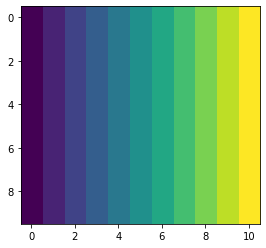

In [237]:
umgrid = np.mgrid[0:Ni, 0:Nj + 1]
vmgrid = np.mgrid[0:Ni + 1, 0:Nj]
u = umgrid[1]/10
v = vmgrid[0]/10
plt.imshow(u, vmin = 0, vmax = 1)

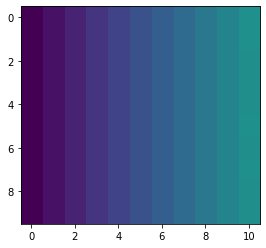

In [241]:
fluid.InitialConditions(u, v, 5)
fluid.step()


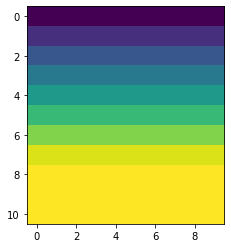

In [211]:
plt.imshow(fluid._v)

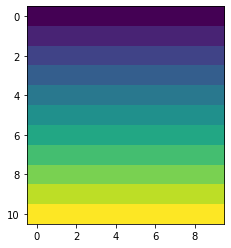

In [213]:
plt.imshow(v)

In [215]:
v - fluid._v

array([[ 0.00000000e+00,  1.89900173e-16,  1.36338244e-15,
         1.33945058e-15, -1.88894768e-15, -4.09503794e-15,
        -8.60442842e-16, -1.69947977e-16, -1.87543020e-15,
         6.94822972e-16],
       [-3.53553391e+01, -3.53553391e+01, -3.53553391e+01,
        -3.53553391e+01, -3.53553391e+01, -3.53553391e+01,
        -3.53553391e+01, -3.53553391e+01, -3.53553391e+01,
        -3.53553391e+01],
       [-7.07106781e+01, -7.07106781e+01, -7.07106781e+01,
        -7.07106781e+01, -7.07106781e+01, -7.07106781e+01,
        -7.07106781e+01, -7.07106781e+01, -7.07106781e+01,
        -7.07106781e+01],
       [-1.06066017e+02, -1.06066017e+02, -1.06066017e+02,
        -1.06066017e+02, -1.06066017e+02, -1.06066017e+02,
        -1.06066017e+02, -1.06066017e+02, -1.06066017e+02,
        -1.06066017e+02],
       [-1.41421356e+02, -1.41421356e+02, -1.41421356e+02,
        -1.41421356e+02, -1.41421356e+02, -1.41421356e+02,
        -1.41421356e+02, -1.41421356e+02, -1.41421356e+02,
        -1.

In [223]:
fluid._u

array([[ 1.11040225e-12,  5.00000000e+04,  1.00000000e+05,
         1.50000000e+05,  2.00000000e+05,  2.50000000e+05,
         3.00000000e+05,  3.50000000e+05,  4.00000000e+05,
         4.50000000e+05,  5.00000000e+05],
       [ 2.11696479e-13,  5.00000000e+04,  1.00000000e+05,
         1.50000000e+05,  2.00000000e+05,  2.50000000e+05,
         3.00000000e+05,  3.50000000e+05,  4.00000000e+05,
         4.50000000e+05,  5.00000000e+05],
       [ 7.27773217e-13,  5.00000000e+04,  1.00000000e+05,
         1.50000000e+05,  2.00000000e+05,  2.50000000e+05,
         3.00000000e+05,  3.50000000e+05,  4.00000000e+05,
         4.50000000e+05,  5.00000000e+05],
       [ 1.79018446e-12,  5.00000000e+04,  1.00000000e+05,
         1.50000000e+05,  2.00000000e+05,  2.50000000e+05,
         3.00000000e+05,  3.50000000e+05,  4.00000000e+05,
         4.50000000e+05,  5.00000000e+05],
       [ 3.04118635e-13,  5.00000000e+04,  1.00000000e+05,
         1.50000000e+05,  2.00000000e+05,  2.50000000e+05,
  

In [230]:
fluid.InitialConditions(u, v, 0.1)
r = fluid.backHeun (fluid._uPos)
b = fluid.fu(r)
b

array([ 2.87141051e-17,  9.00000000e-01,  1.80000000e+00,  2.70000000e+00,
        3.60000000e+00,  4.50000000e+00,  5.40000000e+00,  6.30000000e+00,
        7.20000000e+00,  8.10000000e+00,  9.00000000e+00,  2.88650122e-18,
        9.00000000e-01,  1.80000000e+00,  2.70000000e+00,  3.60000000e+00,
        4.50000000e+00,  5.40000000e+00,  6.30000000e+00,  7.20000000e+00,
        8.10000000e+00,  9.00000000e+00, -6.94679415e-18,  9.00000000e-01,
        1.80000000e+00,  2.70000000e+00,  3.60000000e+00,  4.50000000e+00,
        5.40000000e+00,  6.30000000e+00,  7.20000000e+00,  8.10000000e+00,
        9.00000000e+00,  3.04308413e-18,  9.00000000e-01,  1.80000000e+00,
        2.70000000e+00,  3.60000000e+00,  4.50000000e+00,  5.40000000e+00,
        6.30000000e+00,  7.20000000e+00,  8.10000000e+00,  9.00000000e+00,
        8.60661959e-18,  9.00000000e-01,  1.80000000e+00,  2.70000000e+00,
        3.60000000e+00,  4.50000000e+00,  5.40000000e+00,  6.30000000e+00,
        7.20000000e+00,  

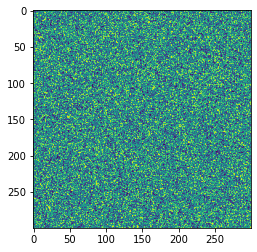

In [41]:
Ni = 100
Nj = 100
X = np.arange(Ni*Nj).reshape((Ni,Nj)) + np.random.rand(Ni, Nj) * Ni
step = np.random.rand(Ni, Nj) * 0.1
fig = plt.figure()
axis = plt.axes()
def animate(i):
  global X
  X = X + step
  colors = np.sin(X)
  axis.clear()
  image = axis.imshow(colors)
  return image
myAnim = animation.FuncAnimation(fig, animate, interval = 50, frames = 100)

f = '/content/drive/MyDrive/Animaciones/test.gif'
writervideo = animation.PillowWriter(fps=30) 

myAnim.save(f, writer = writervideo)

  



In [57]:
X = np.mgrid[0:11, 0:10][0].flatten()

In [58]:
X

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10])